In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

# Fast Fourier Transform - DSP Lyons Ch4

FFT is superior to the classic DFT, use te radix-2 FFT algorithm. To review, for an $N$-point DFT, the frequency domain of the signal $x(n)$ is:

$$X(m) = \sum_{n=0}^{N-1}x(n)e^{-j2\pi n m / N} $$

The number of complex multiplications for an $N$-point FFT is $N/2\cdot\log_2N$, which is reduced from $N^2$ for the DFT.

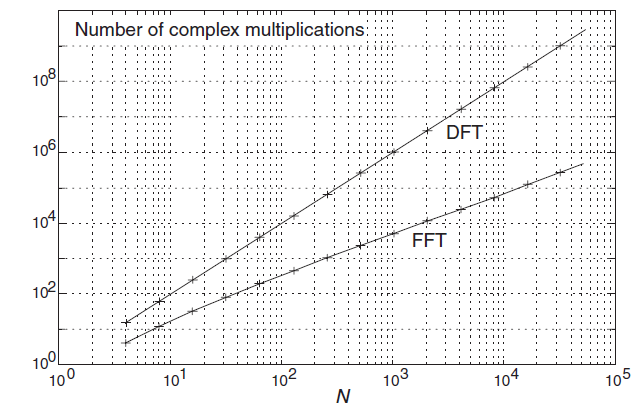

## Best practices for FFTs in practice:

1. Sample fast enough and long enough: When digitizing continuous signals with an A/D converter, for example, we know, from Chapter 2, that our sampling rate must be greater than twice the bandwidth of the continuous A/D input signal to prevent frequency domain aliasing. Depending on the application, practitioners typically sample at 2.5 to 4 times the signal bandwidth. We should **mistrust** any FFT results that have significant spectral components **at frequencies near half the sample rate**. Ideally, we’d like to work with signals whose spectral amplitudes **decrease** with increasing frequency. 

- Be very suspicious of aliasing if there are any spectral components whose **frequencies appear to depend on the sample rate**. If we suspect that aliasing is occurring or that the continuous signal contains broadband noise, we’ll have to use an **analog lowpass filter prior to A/D conversion**. The cutoff frequency of the lowpass filter must, of course, be greater than the frequency band of interest but less than half the sample rate.

- How many samples must we collect before we perform our FFT? The answer is that the data collection time interval must be long enough to satisfy our desired FFT frequency resolution for the given sample rate $f_s$. So, for example, if we need a spectral resolution of 5 Hz, then fs/N = 5 Hz, and

$$ N = \frac{f_s}{\text{desired resolution}} = \frac{f_s}{5} = 0.2f_s$$ 

- In this case, if $f_s$ is, say, 10 kHz, then $N$ must be at least 2000, and we’d choose $N$ equal to 2048 because this number is a power of two.

2. Manipulating the Time Data Prior to Transformation

- When using the radix-2 FFT, if we don’t have control over the length of our time-domain data sequence, and that sequence length is not an integral power of two, we have two options. We could discard enough data samples so that the remaining FFT input sequence length is some integral power of two. This scheme is not recommended because ignoring data samples degrades our resultant frequency-domain resolution. (The larger N is, the better our frequency resolution, right?) A better approach is to append enough zero valued samples to the end of the time data sequence to match the number of points of the next largest radix-2 FFT.

- FFTs suffer the same ill effects of spectral leakage that we discussed for the DFT. If appending zeros is necessary to extend a time sequence, **we have to make sure that we append the zeros after multiplying the original time data sequence by a window function**. Applying a window function to the appended zeros will distort the resultant window and worsen our FFT leakage problems.

- Although windowing will reduce leakage problems, it will not eliminate them altogether. Even when windowing is employed, high-level spectral components can obscure nearby low-level spectral components. This is especially evident when the original time data has a nonzero average, i.e., it’s riding on a DC bias.

- We can eliminate this problem by calculating the average of the time sequence and subtracting that average value from each sample in the original sequence. (The averaging and subtraction process must be performed before windowing.)

3. Enhancing FFT Results: If we’re using the FFT to detect signal energy in the presence of noise and enough time-domain data is available, we can improve the sensitivity of our processing by averaging multiple FFTs. Implement to detect signal energy that’s actually below the average noise level; that is, given enough time-domain data, we can detect signal components that have negative signal-to-noise ratios.

4. Interpreting FFT Results: The first step in interpreting FFT results is to compute the absolute frequency of the individual FFT bin centers. Like the DFT, the FFT bin spacing is the ratio of the sampling rate ($f_s$) over the number of points in the FFT, or $f_s/N$.

- $m=0,1,2,..,N-1$ the absolute frequency of the $m$th bin center is $mf_s/N$. For a real-only input sampels, only the $X(m)$ ouputs from $m=0$ to $m=N/2$ are independent.

- True amplitude of time-domain signals from their FFT results: $X(m) = X_{real}(m) + jX_{imag}(m)$ with magnitudes

$$X_{mag}(m) = |X(m)| = \sqrt{X_{real}(m)^2 + X_{imag}(m)^2} $$ 

(note these magnitudes are *inherently* multiplied by a factor of $N/2$ (see week 3 notebook) when the samples are **real**. For complex samples, the scaling factor is $N$.) 

- If a window function was used on the original time-domain data, some of the FFT input samples will be attenuated. This reduces the resultant FFT output magnitudes from their true unwindowed values. To calculate the correct amplitudes of various time-domain sinusoidal components, then, we’d have to further divide the FFT magnitudes by the appropriate processing loss factor associated with the window function used.

- Normalized power spectrum of a FFT result in dB (decibels): 

$$\text{normalized} X_{dB}(m) = 20\cdot \log_{10}\left( \frac{|X(m)|}{|X(m)|_{max}}\right) $$

where $|X(m)|_{max}$ is the largest FFT output magnitude sample.  

- In practice, we find that plotting XdB(m) is very informative because of the enhanced low-magnitude resolution afforded by the logarithmic decibel scale.

- Phase angels $X_{\emptyset}(M)$ of the individual FFT outputs are:

$$ X_{\emptyset}(M) = \tan^{-1}\left(\frac{X_{imag}(m)}{X_{real}(m)}\right) $$

In [2]:
# Challenge. Implement DFT from scratch and compare with FFT from numpy

# Numpy
N = 1024 # Hz, N = fs sampling rate * T duration
T = 1.0
f1, f2 = 500, 100
t = np.linspace(0,T,N,endpoint=False) 
x = 0.5*np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)
X = np.fft.fft(x)
freqs = np.fft.fftfreq(len(t),1/N)

# Manual DFT
def fourier_coeff(data,N,k):
    n = np.arange(N)
    c_k = (1/N)*np.sum(data*np.exp(-(1j)*2*np.pi*n*k/N))
    return c_k

def manual_fftfreq(N, T=1.0):
    return np.concatenate((np.arange(0, N//2), np.arange(-N//2, 0))) / (N * T)

manual_coeff = []

for k in range(0,N):
    ck = fourier_coeff(x,N,k) 
    manual_coeff.append(ck)
    
manual_freq = manual_fftfreq(N,T/N)

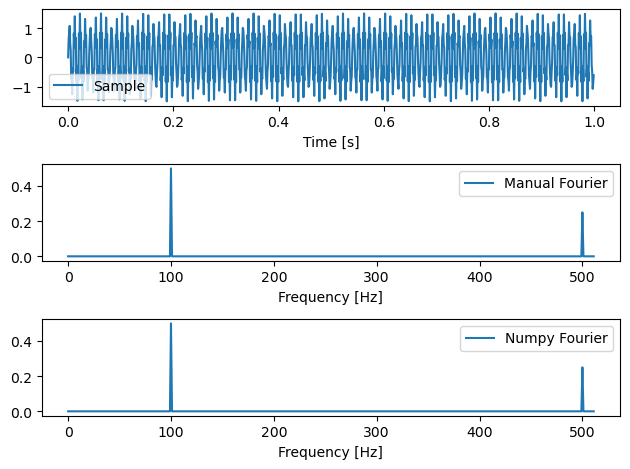

In [3]:
fig, ax = plt.subplots(3,1)

x_label = ['Time [s]','Frequency [Hz]','Frequency [Hz]']

ax[0].plot(t,x,label=f'Sample')
ax[1].plot(manual_freq[:N//2],np.abs(manual_coeff[:N//2]),label=r'Manual Fourier')
ax[2].plot(freqs[:N//2],np.abs(X[:N//2])/len(t),label='Numpy Fourier')
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel(x_label[i])
fig.tight_layout()

Text(0, 0.5, 'Power [dB]')

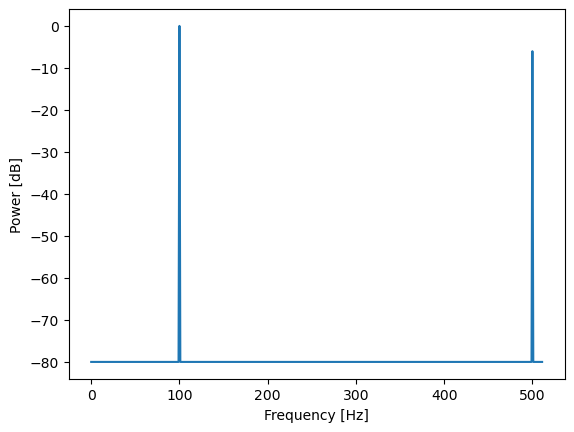

In [4]:
# Power spectrum

X_mag = np.abs(X)  # Magnitude of FFT

# Normalize and convert to dB
X_dB = 20 * np.log10(X_mag / np.max(X_mag))

# Common practice to clip to -80 decibels, anything below -100 decibels is machine precision error
X_dB_clipped = np.clip(X_dB, -80, 0)

plt.plot(freqs[:N//2],X_dB_clipped[:N//2])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [dB]')


# Second challenge - Real audio file

In [34]:
# Challenge: Apply FFT to an audio file and analyze its frequency spectrum
from pydub import AudioSegment 

file_path = 'The Black Mages - J-E-N-O-V-A.mp3'
jenova = AudioSegment.from_mp3(file_path)
jenova = jenova.set_channels(1)

In [35]:
samples = np.array(jenova.get_array_of_samples())

In [36]:
fs = 44100 # In Hz, 44.1 kHz is standard
d=1/fs
X_jenova = np.fft.fft(samples)

In [37]:
freqs_jenova = np.fft.fftfreq(len(samples),d)

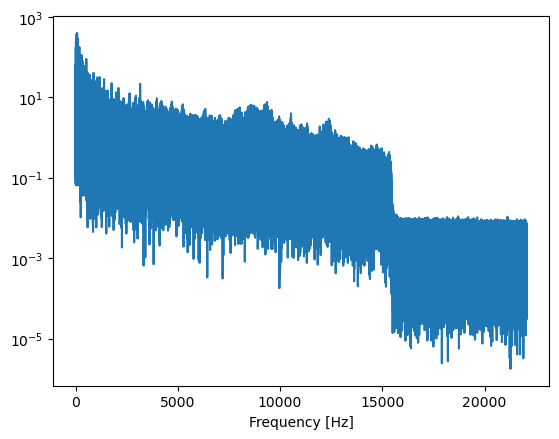

In [38]:
N = len(samples)
plt.plot(freqs_jenova[:N//2],np.abs(X_jenova[:N//2])/N,label=r'Black Mages: JENOVA spectrum')
plt.xlabel('Frequency [Hz]')
plt.yscale('log')

# comments: The first half of the spectrum is correct. 
# Not sure why the second half is the way it is. Perhaps something about the way it's averaged across channels?

Text(0, 0.5, 'Power [dB]')

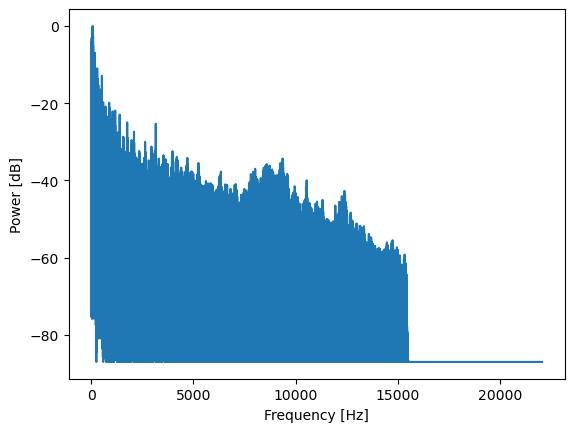

In [40]:
# Power spectrum
X_mag = np.abs(X_jenova)  # Magnitude of FFT

# Normalize and convert to dB
X_dB_jenova = 20 * np.log10(X_mag / np.max(X_mag))

# Common practice to clip to -80 decibels, anything below -100 decibels is machine precision error
X_dB_jenova_clipped = np.clip(X_dB_jenova, -87, 0)

plt.plot(freqs_jenova[:N//2],X_dB_jenova_clipped[:N//2])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [dB]')

# DSP Lyons Ch5

## Finite Impulse Response Filters

Introduce the fundamental attributes of digital filters, learn how to quantify their performance, and review the principles associated with the design of finite impulse response digital filters. In general, filtering is the processing of a time-domain signal resulting in some change in that signal’s original spectral content. The change is usually the reduction, or filtering out, of some unwanted input spectral components; that is, filters allow certain frequencies to pass while attenuating other frequencies. Where an analog filter operates on a continuous signal, a digital filter processes a sequence of discrete sample values. Filters can be a software program in a computer, a programmable hardware processor, or a dedicated integrated circuit.

- Finite impulse response (FIR) filters and infinite impulse response (IIR) filters.

- Given a finite duration of nonzero input values, an FIR filter will always have a finite duration of nonzero output values. So, if the FIR filter’s input suddenly becomes a sequence of all zeros, the filter’s output will eventually be all zeros.

- FIR filters use addition to calculate their outputs in a manner much the same as the process of averaging uses addition. In fact, averaging is a kind of FIR filter.

- The averager output sequence is considerably smoother than the input sequence. Knowing that sudden transitions in a time sequence represent high-frequency components, we can say that our averager is behaving like a lowpass filter and smoothing sudden changes in the input. Is our averager an FIR filter? It sure is—no previous averager output value is used to determine a current output value; only input values are used to calculate output values.

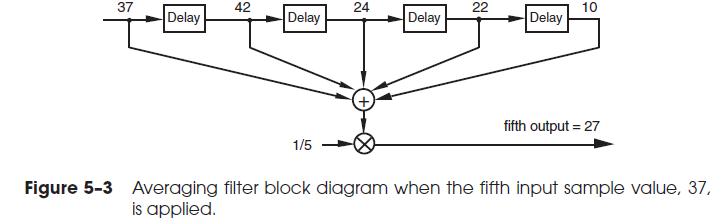

We can formalize the digital filter nature of our averager by creating the block diagram in Figure 5–3 showing how the averager calculates its output samples.
This block diagram, referred to as the filter structure, is a physical depiction of how we might calculate our averaging filter outputs with the input sequence of values shifted, in order, from left to right along the top of the filter as new output calculations are performed. This structure shows those values used when the first five input sample values are available. The delay elements in Figure 5–3, called **unit delays**, merely indicate a shift register arrangement where input sample values are temporarily stored during an output calculation.

- The filter’s structure using this bucket brigade shifting process is often called a transversal filter due to the cross-directional flow of the input samples. Because we tap off five separate input sample values to calculate an output value, the structure in Figure 5–4 is called a 5-tap tapped-delay line FIR filter, in digital filter vernacular.

One important and, perhaps, most interesting aspect of understanding FIR filters is learning how to predict their behavior when sinusoidal samples of various frequencies are applied to the input, i.e., how to estimate their frequency-domain response. Two factors affect an FIR filter’s frequency response: the number of taps and the specific values used for the multiplication
coefficients.

For a general $M$-tap FIR filter, the $n$th output is 

$$ y(n) = \sum_{k=0}^{M-1} h(k)x(n-k) = h(k) * x(n) $$

Hey! This is the convolution equation! is merely a series of multiplications followed by the addition of the products. The process is actually rather simple. We just flip the time order of an input sample sequence and start stepping the flipped sequence across the filter’s coefficients. For each new filter input sample, we sum a series of products to compute a single filter output value. The **impulse response** of a filter is exactly what its name implies—it’s the filter’s output time-domain sequence when the input is a single unity-valued sample (impulse) preceded and followed by zero-valued samples.Notice the key point here: the FIR filter’s impulse response is identical to the five filter coefficient values. For this reason, the terms FIR filter coefficients and impulse response are synonymous. Thus, when someone refers to the impulse response of an FIR filter, they’re also talking about the coefficients. Because there are a finite number of coefficients, the impulse response will be finite in time duration (finite impulse response, FIR).

As it turns out, our filter’s **performance** can be improved by using coefficients whose values are not all
the same. By “performance” we mean *how well the filter passes desired signals and attenuates unwanted signals*. We judge that performance by determining the shape of the filter’s frequency-domain response that we obtain by the convolution property of linear systems.

The process of convolution, as it applies to FIR filters, is as follows: the discrete Fourier transform (DFT) of the convolution of a filter’s impulse response (coefficients) and an input sequence is equal to the product of the spectrum of the input sequence and the DFT of the impulse response.

The idea we’re trying to convey here is that if two time domainsequences $h(k)$ and $x(n)$ have DFTs of $H(m)$ and $X(m)$, respectively, then the DFT of $y(n) = h(k)*x(n)$ is $H(m) ·X(m)$.
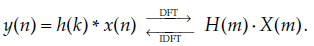

**Convolution in the time domain is equivalent to multiplication in the frequency domain.**

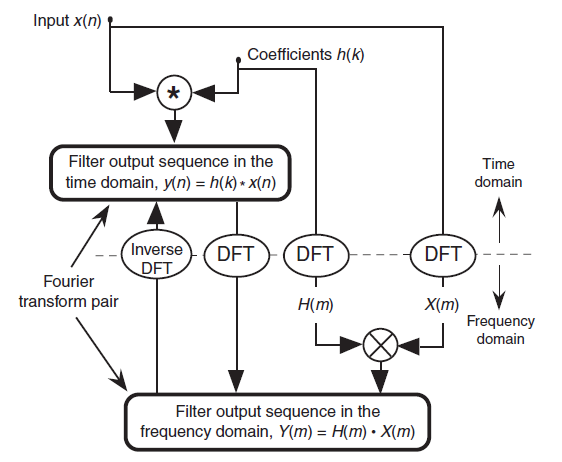

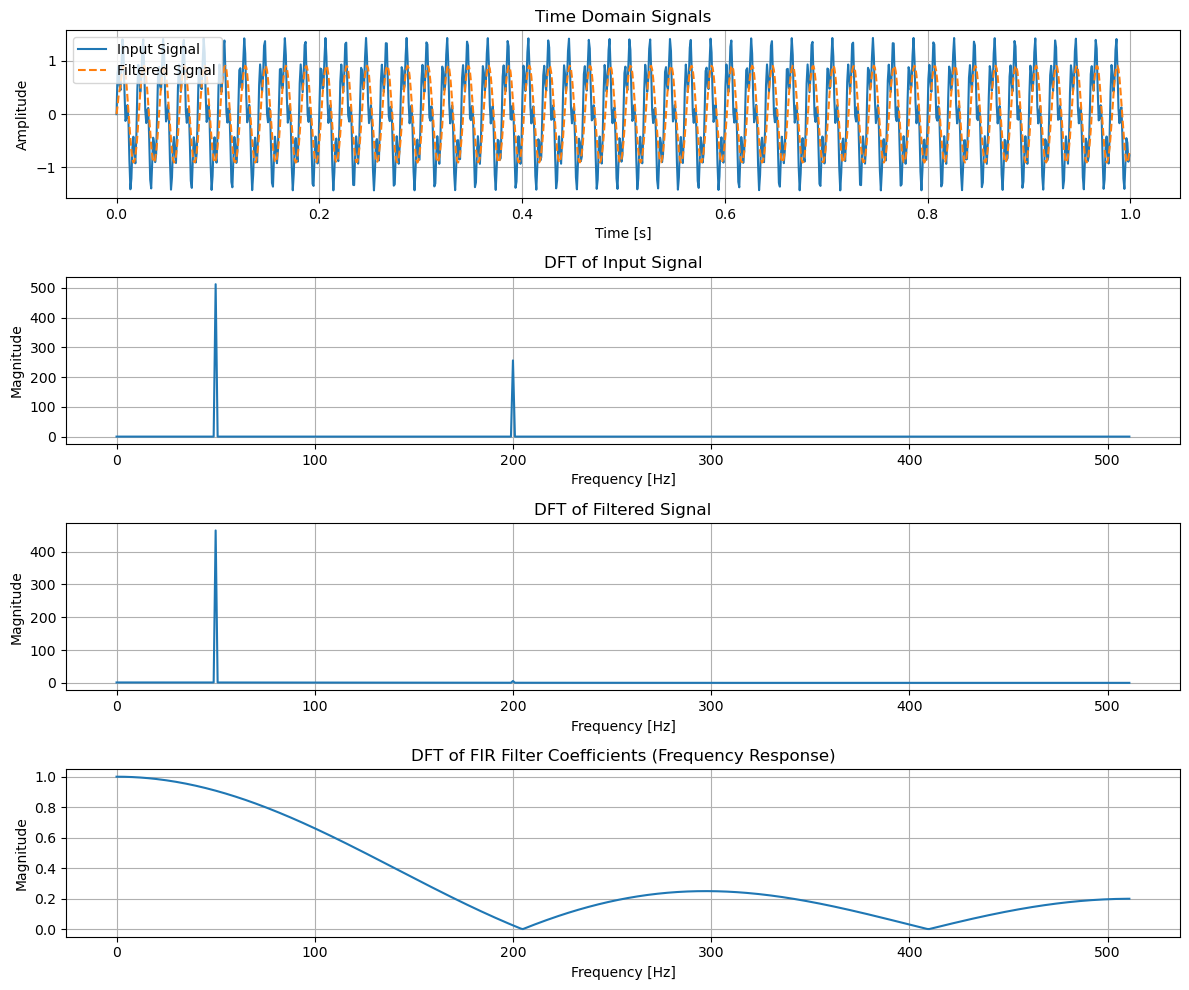

In [4]:
from scipy.signal import lfilter

# Parameters
fs = 1024          # Sampling frequency (Hz)
t = np.arange(0, 1.0, 1/fs)  # 1 second of data

# Generate input signal: sum of two sine waves
f1, f2 = 50, 200
x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

# FIR Filter: Simple moving average filter (low-pass)
N = 5 # This is a moving average filter of order 5.
b = np.ones(N) / N  # FIR coefficients (moving average)
a = [1]             # Denominator for FIR,  since this is a FIR filter, there’s no feedback (IIR would have a != 1).

# Apply FIR filter
y = lfilter(b, a, x)

# Compute DFT using FFT
X = np.fft.fft(x)
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(t), d=1/fs)

# FFT of the FIR filter (zero-padded to same length as signal)
H = np.fft.fft(b, n=len(t))
H_mag = np.abs(H)

# Keep only positive frequencies
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
X_mag = np.abs(X)[pos_mask]
Y_mag = np.abs(Y)[pos_mask]
H_mag = H_mag[pos_mask]

# Plotting
plt.figure(figsize=(12, 10))

# Time domain signals
plt.subplot(4, 1, 1)
plt.plot(t, x, label='Input Signal')
plt.plot(t, y, label='Filtered Signal', linestyle='--')
plt.title('Time Domain Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# DFT of input
plt.subplot(4, 1, 2)
plt.plot(freqs_pos, X_mag)
plt.title('DFT of Input Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()

# DFT of filtered output
plt.subplot(4, 1, 3)
plt.plot(freqs_pos, Y_mag)
plt.title('DFT of Filtered Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()

# DFT of the FIR filter (frequency response)
plt.subplot(4, 1, 4)
plt.plot(freqs_pos, H_mag)
plt.title('DFT of FIR Filter Coefficients (Frequency Response)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()

plt.tight_layout()
plt.show()


Suppose we applied a low-frequency sinewave to a 5-point averaging FIR filter. The input sinewave’s frequency is $f_s/32$ Hz and its peak amplitude is unity. First, the filter’s output is a sinewave of the same frequency as the input. This is a characteristic of a linear system.

We apply a single sinewave input, and the output will be a single sinewave (shifted in phase and perhaps reduced in amplitude) of the **same frequency as the input**. Second, notice that the initial four output samples are not exactly sinusoidal. Those output samples are the **transient response of the filter**. With tapped-delay line FIR filters, the sample length of that transient response is equal to the number of filter unit-delay elements D, after which the filter’s output begins its steady-state time response.

It means that tapped-delay line FIR filter outputs are not valid until $D+1$ input samples have been applied to the filter. That is, the output samples are not valid until the filter’s delay line is filled with input data. The input/output delay
measured in samples is equal to half the number of unit-delay elements in the filter’s tapped-delay line (not dependent on frequency). 

The point is, we don’t have to implement an FIR filter and apply various sinewave inputs to discover what its frequency response will be. We need merely take the DFT of the FIR filter’s coefficients (impulse response) to determine the filter’s frequency response.

### Summary so far

- FIR filters perform time-domain convolution by summing the products of the shifted input samples and a sequence of filter coefficients

- an FIR filter’s output sequence is equal to the convolution of the input sequence and a filter’s impulse response (coefficients)

- an FIR filter’s frequency response is the DFT of the filter’s impulse response

- an FIR filter’s output spectrum is the product of the input spectrum and the filter’s frequency response

- convolution in the time domain and multiplication in the frequency domain are Fourier transform pairs

### Note:

-First, as we expected, different sets of coefficients give us different frequency magnitude responses. 

-Second, a sudden change in the values of the coefficient sequence, such as the 0.2 to 0 transition in the first coefficient set, causes ripples, or sidelobes, in the frequency response. 

-Third, if we minimize the suddenness of the changes in the coefficient values, such as the third set of coefficients, we reduce the sidelobe ripples in the frequency response. However, reducing the sidelobes results in increasing the main lobe width of our lowpass filter.

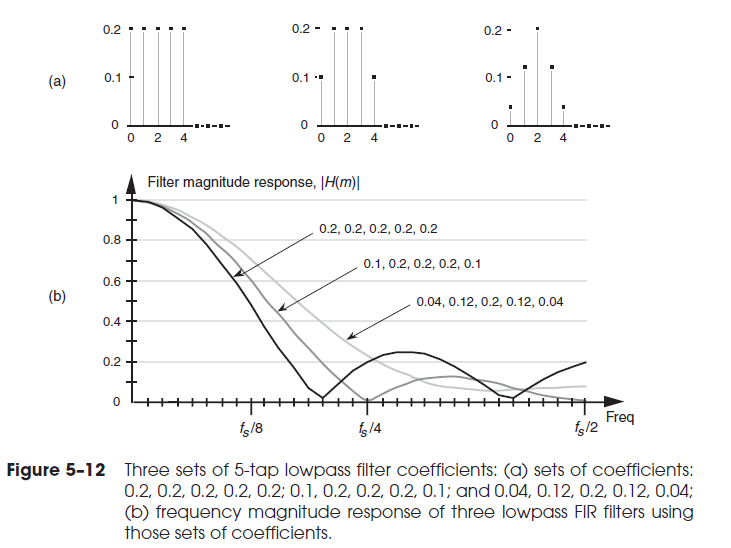

## Lowpass Filter Design

The design procedure starts with the determination of a desired frequency response followed by calculating the filter coefficients that will give us that response. There are two predominant techniques used to design FIR filters: the window method and the so-called optimum method.